# Building Customer Churn Prediction Model

This project aims to analyze user behavior, design an experiment, and build a predictive model for Ultimate, a ride-sharing company. The goals include understanding user login behavior, assessing the impact of reimbursing toll costs on driver availability, and predicting user retention.

&nbsp;
### For the purposes of this project and to emulate a realistic business scenario, the following constraints and success criteria have been assumed:

Project Constraints:
- **Time Constraints:** Leadership is concerned about the urgency to act swiftly on user retention. Consequently, a timeframe of 3-week has been allocated for the design of the A/B test and the development of a Minimum Viable Product (MVP) model. The business favors a rapid deployment of an initial, potentially imperfect solution over a delayed but refined model, with plans to iteratively improve the model based on new findings and evolving business priorities.
- **Data Quality and Availability:** The integrity and accessibility of the data may impact project outcomes. Additionally, the derived insights and model performance are constrained by the dataset's scope, which exclusively includes users who signed up in January 2014, along with selected trip statistics (e.g., average rating, distance, last trip date) from January to June 2014. 
&nbsp;

Success Criteria:
- **Model Performance:** The model should achieve a minimum accuracy of 70% and a recall of 75%. Emphasizing recall indicates a strategic choice to invest more in marketing efforts rather than missing out on identifying users at risk of churning.
- **A/B Test Clarity:** The A/B test design must offer clear instructions on execution and articulate any potential constraints or limitations.
Insights from EDA: The exploratory data analysis should yield actionable insights, enabling the business to begin developing strategies in anticipation of further model development.

&nbsp;
### Datasource Provided:
**logins.json:** This dataset contains timestamps of user logins in a particular geographic location.
**ultimate_data_challenge.json:** This dataset includes detailed user profiles for a cohort of users who signed up for an Ultimate account **in January 2024**, encompassing aspects like city, sign up date, and some trip statistics.


## Table of Contents
1. [Part 0 - Data Wrangling, QA, & Outlier Check](#part-0---data-wrangling-qa--outlier-check)
2. [Part 1 - Analyzing User Login Behavior](#part-1---analyzing-user-login-behavior)
3. [Part 2 - A/B Test Experiment Design](#part-2---ab-test-experiment-design)
4. [Part 3 - Predictive Modeling for Rider Retention](#part-3---predictive-modeling-for-rider-retention)

## Part 0 - Data Wrangling, QA, & Outlier Check

&nbsp;
TLDR; Summary of Data Quality and Outliers:

Missing Values:
- `avg_rating_of_driver` has significant missing values, constituting approximately 16% of the dataset, potentially due to the rating being optional. A strategy to address these missing values needs to be defined during the data preprocessing phase.
- `avg_rating_by_driver` shows less than 1% missing values, suggesting drivers are consistent with ratings, and dropping these may not significantly impact analysis.
- `phone` also has a minor proportion of missing values. Options include imputation to preserve distribution or removal, which should not heavily influence the overall analysis.

Duplicates:
- In `df_logins`, less than 1% of login timestamps are duplicates, likely due to concurrent logins, and will be retained for now given the absence of evidence suggesting they're invalid.
- `df_user_profile` has a very small number (0.1%) of complete row duplicates, likely to be true duplicates given the improbability of such coincidences in sign-up and activity data.

Outliers in Numerical Data:
- The majority of users have less than 10 trips in the first 30 days, but some outliers show 60 or more trips.
- Driver ratings are generally high, but a few outliers reflect much lower ratings.
- Surge pricing affected a small percentage of trips for most users, yet some outliers experienced surges in over half of their trips.
- Weekday trip distribution is broad, but outliers exclusively used the service on weekdays or weekends.
- Average trip distances in the first 30 days are typically below 15 miles, with outliers traveling 60 miles or more.
- Driver ratings for users are predominantly high, with outliers receiving ratings below 3.
- These points summarize the key data quality considerations, the presence of duplicates, and the extent and impact of outliers, providing a snapshot of the data's overall integrity for further analysis.

### 1. Load necessary libraries and datasets

In [599]:
# Import Libraries

# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set_style('darkgrid')

# Statistical Analysis
import statsmodels.api as sm
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Load "login times" json as dataframe

In [600]:
# Load Login Times
df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Load "user profile" json as dataframe.

Data Semantic (some columns are renamed for better clarity):
- **city:** city this user signed up in
- **phone:** primary device for this user
- **signup_date:** date of account registration; in the form ‘YYYYMMDD’
- **last_trip_date:** the last time this user completed a trip; in the form ‘YYYYMMDD’
- **avg_dist (renamed to "avg_per_trip_distance_miles_first_30_days"):** the average distance in miles per trip taken in the first 30 days after signup
- **avg_rating_by_driver:** the rider’s average rating over all of their trips
- **avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips
- **surge_pct (renamed to "percentage_of_trip_with_surge"):** the percent of trips taken with surge multiplier > 1
- **avg_surge (renamed to "percentage_of_trip_with_surge"):** The average surge multiplier over all of this user’s trips
- **trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up
- **ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- **weekday_pct (renamed to "pct_of_trips_taken_during_weekday"):** the percent of the user’s trips occurring during a weekday

In [601]:
# Load User Profile
df_user_profile = pd.read_json('ultimate_data_challenge.json')

# Renaming columns for more clarity
df_user_profile.rename(
        columns={
        'avg_dist': 'avg_per_trip_distance_miles_first_30_days', 
        'surge_pct': 'percentage_of_trip_with_surge', 
        'avg_surge': 'avg_surge_multiplier',
        'weekday_pct': 'pct_of_trips_taken_during_weekday'
    }, 
    inplace=True
)

df_user_profile.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge_multiplier,last_trip_date,phone,percentage_of_trip_with_surge,ultimate_black_user,pct_of_trips_taken_during_weekday,avg_per_trip_distance_miles_first_30_days,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 1. Data Quality Checks

#### Convert date types columns

In [602]:
# Converting columns to the right format with error hyandling
dates_col_to_convert = ['signup_date', 'last_trip_date']
for col in dates_col_to_convert:
    df_user_profile[col] = pd.to_datetime(df_user_profile[col], errors='coerce', yearfirst=True)

# Confirm successful conversion
df_user_profile[dates_col_to_convert].head()

,signup_date,last_trip_date
0,2014-01-25,2014-06-17
1,2014-01-29,2014-05-05
2,2014-01-06,2014-01-07
3,2014-01-10,2014-06-29
4,2014-01-27,2014-03-15


#### Check for missing values

In [603]:
df_logins.isnull().sum()

login_time    0
dtype: int64

There are missing values on "df_user_profile":
- "avg_rating_of_driver" has approximately 16% missing values, which might be attributed to the optional nature of rating a driver after a trip. Strategies for handling this will need to be considered during data preprocessing.
- "avg_rating_by_driver" shows less than 1% missing values, indicating that drivers tend to provide ratings more consistently than riders. Given the small percentage, removing these instances is unlikely to significantly affect the overall data integrity or the predictive modeling outcomes.
- "phone" also has less than 1% missing data. Imputing this based on the existing distribution could prevent introducing bias, while outright removal should have minimal impact on the dataset's representativeness.

In [604]:
print(f'Total Rows: {len(df_user_profile)}')
df_user_profile.isnull().sum().sort_values(ascending=False)

Total Rows: 50000


avg_rating_of_driver                         8122
phone                                         396
avg_rating_by_driver                          201
city                                            0
trips_in_first_30_days                          0
signup_date                                     0
avg_surge_multiplier                            0
last_trip_date                                  0
percentage_of_trip_with_surge                   0
ultimate_black_user                             0
pct_of_trips_taken_during_weekday               0
avg_per_trip_distance_miles_first_30_days       0
dtype: int64

#### Check for duplicate entries

The `df_logins` dataset contains 877 instances of duplicated "login_time" entries, which is less than 1% of the data. These may represent simultaneous logins by different users and will be retained due to the lack of clear evidence that they are inaccuracies. 

In [605]:
# Print dupe count
observation_count = len(df_logins)
dupe_count = df_logins.duplicated().sum()
print(f'There are {dupe_count} observation repeated twice, out of {observation_count-dupe_count} unique observations in total (<1 %).')

# Show dupe sample
df_logins[df_logins.duplicated(keep=False)].sort_values(by='login_time').head(8) # The "keep=False" is to mark all duplicates as True

There are 877 observation repeated twice, out of 92265 unique observations in total (<1 %).


,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
506,1970-01-02 15:08:27
521,1970-01-02 16:14:36
524,1970-01-02 16:14:36


For the `df_user_profile` dataset, 8 observations are duplicated. The probability that these duplicates are due to chance, considering the specificity of the data (e.g., sign-up date, trip count, and distance), is very low. These duplicates are likely errors and should be removed.

In [606]:
# Print dupe count
observation_count = len(df_user_profile)
dupe_count = df_user_profile.duplicated().sum()
print(f'There are {dupe_count} observation repeated twice, out of {observation_count-dupe_count} unique observations in total (<0.1 %).')

df_user_profile[df_user_profile.duplicated(keep=False)].sort_values(by=['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_by_driver']) # The "keep=False" is to mark all duplicates as True

There are 8 observation repeated twice, out of 49992 unique observations in total (<0.1 %).


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge_multiplier,last_trip_date,phone,percentage_of_trip_with_surge,ultimate_black_user,pct_of_trips_taken_during_weekday,avg_per_trip_distance_miles_first_30_days,avg_rating_by_driver
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0


In [607]:
# Drop the duplicates
print(f'Total rows: {observation_count}')
print(f'Rows to drop: {dupe_count}')
df_user_profile.drop_duplicates(keep='first', inplace=True)
print(f'Row count after removing the duplicates: {len(df_user_profile)}')

Total rows: 50000
Rows to drop: 8
Row count after removing the duplicates: 49992


### Check for Outliers

#### "df_logins" dataframe Outliers


Not sure if it's intentional but the login times seemed to be from the year 1970. This needs to be clarified further with the system/database owner as this is almost certainly can't be true, unless intentional for the purpose of this case study. 

In [608]:
df_logins.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


#### "df_user_profile" - Date Columns Outliers
No indication of outliers, "signup_date" seemed to be in January 2014 and "last_trip_date" seemed to follow the assumed Jan - Jun 2014 period. 

In [609]:
df_user_profile.select_dtypes(include=[np.datetime64]).describe()

,signup_date,last_trip_date
count,49992,49992
mean,2014-01-16 13:04:52.078732800,2014-04-19 08:23:49.284685568
min,2014-01-01 00:00:00,2014-01-01 00:00:00
25%,2014-01-09 00:00:00,2014-02-14 00:00:00
50%,2014-01-17 00:00:00,2014-05-08 00:00:00
75%,2014-01-24 00:00:00,2014-06-18 00:00:00
max,2014-01-31 00:00:00,2014-07-01 00:00:00


#### "df_user_profile" - Categorical Columns Outliers
No indication of outliers. 

In [610]:
df_user_profile.select_dtypes(include=[object, bool]).describe()

,city,phone,ultimate_black_user
count,49992,49596,49992
unique,3,2,2
top,Winterfell,iPhone,False
freq,23331,34578,31141


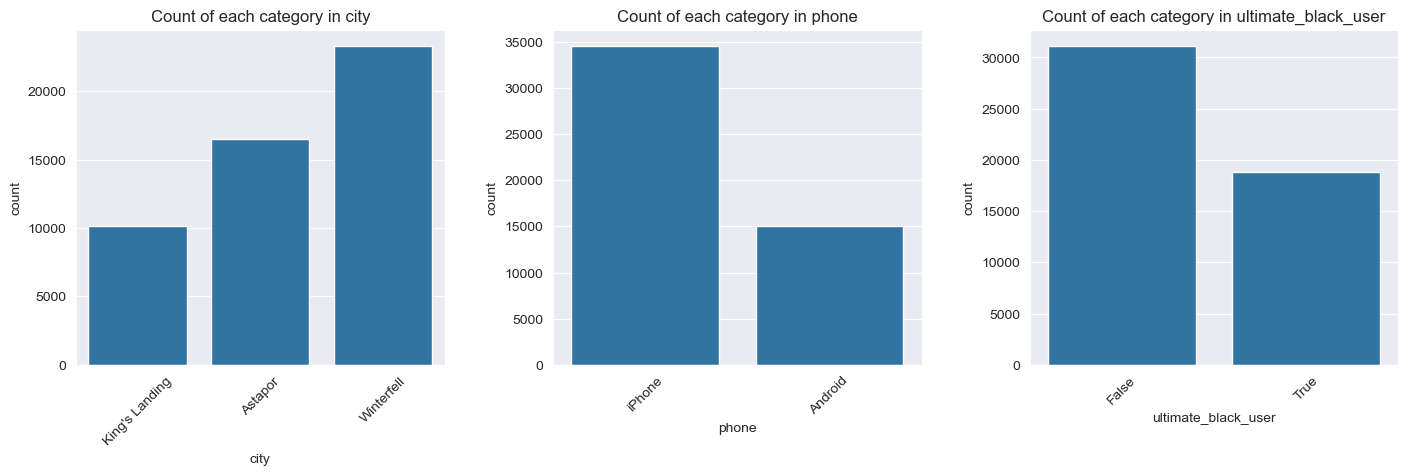

In [611]:
df_user_profile_categorical_only = df_user_profile.select_dtypes(include=[object, bool])

# Determine the number of columns and the total number of plots needed
n_cols = df_user_profile_categorical_only.columns.size
n_rows = (n_cols + 2) // 3  # Ensure there's enough rows in the grid

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))
fig.tight_layout(pad=5.0)  # Add space between plots

for i, col in enumerate(df_user_profile_categorical_only.columns):
    row = i // 3
    col_pos = i % 3
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]  # Adjust for when there's only one row
    sns.countplot(x=col, data=df_user_profile_categorical_only, ax=ax)
    ax.set_title(f'Count of each category in {col}')
    ax.tick_params(axis='x', rotation=45)  # Rotate labels if they overlap

# Hide any unused axes if the number of plots is not a multiple of 3
if n_cols % 3:
    for i in range(3 - (n_cols % 3)):
        axes.flat[-(i+1)].set_visible(False)
        
plt.show()


#### "df_user_profile" - Numerical Columns Outliers

Looking at the boxplot below:
- Trips in the first 30 days: Most users take fewer than 10 trips, with outliers representing a small number of users taking more than 60 trips.
- Average rating of driver: Ratings are generally high, with outliers consisting users who generally gave lower ratings (3.5 or below).
- Average surge multiplier: The majority of trips incur no surge or a minor increase, but there are outliers with surge multipliers exceeding 4 times the base rate.
- Surge percentage: While half of the trips have 10% or less affected by surge pricing, outliers include those with more than 50% of trips during surge times, possibly indicating users who frequently travel during peak hours.
- Percentage of trips during weekdays: There is an even distribution across the board, but outliers exist for users who exclusively travel on weekdays or weekends.
- Average distance: Generally, users travel 15 miles or less per trip in their first 30 days, yet outliers indicate some users average over 60 miles per trip.
- Average rating by driver: Users are typically rated above 4.25, with outliers receiving ratings below 3.

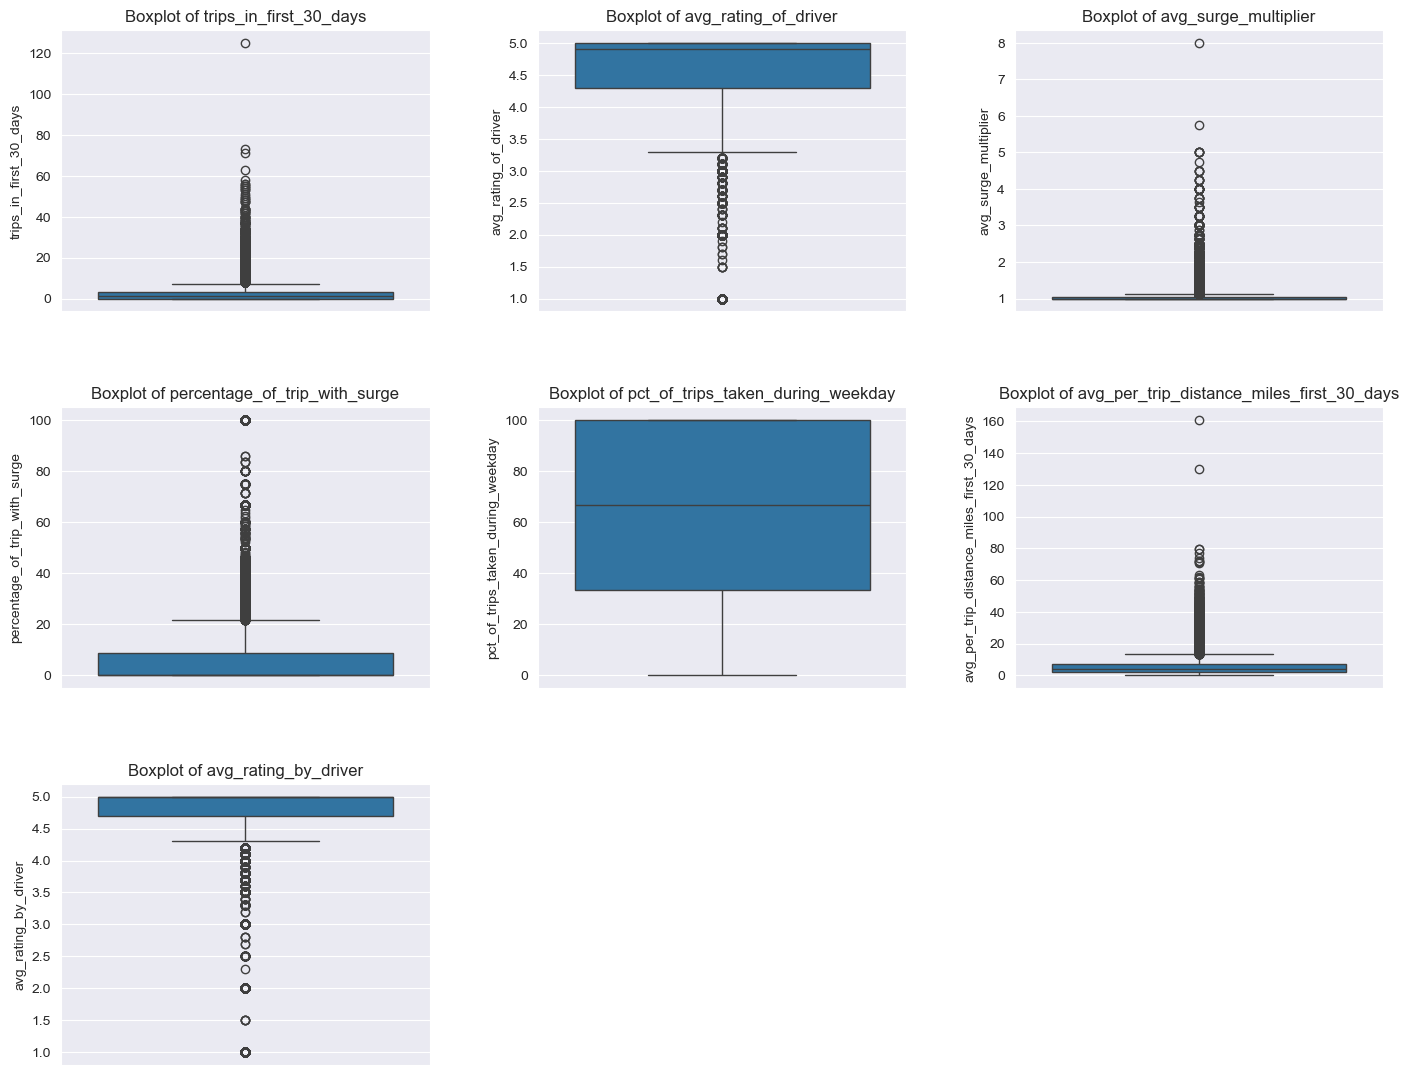

In [612]:
# Select only numerical columns
df_user_profile_numerical_only = df_user_profile.select_dtypes(include=[float, int])

# Determine the number of columns and the total number of plots needed
n_cols = df_user_profile_numerical_only.columns.size
n_rows = (n_cols + 2) // 3  # Ensure there's enough rows in the grid

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
fig.tight_layout(pad=5.0)  # Add space between plots

for i, col in enumerate(df_user_profile_numerical_only.columns):
    row = i // 3
    col_pos = i % 3
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]  # Adjust for when there's only one row
    sns.boxplot(y=col, data=df_user_profile_numerical_only, ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Hide any unused axes if the number of plots is not a multiple of 3
if n_cols % 3:
    for i in range(3 - (n_cols % 3)):
        axes.flat[-(i+1)].set_visible(False)
        
plt.show()


## Part 1 - Analyzing User Login Behavior

**NOTE:** Since the provided dataset (`logins.json`) doesn't have geographic location, we'll proceed with the only available field `login_time`.

&nbsp;
TLDR; Summary of Time Series Analysis:

15-minute Interval Trends:
- Time series plots at 15-minute intervals reveal noticeable fluctuations in activity, suggesting specific times when logins surge that merit further analysis.
- A preliminary examination of the data from the first week of January 1970 hints at potential recurring patterns during certain hours, prompting a need for a detailed seasonal pattern analysis.

Hourly Activity Patterns:
- Distinct login peaks occur in the early morning hours (1-2 AM) and late evening (10-11 PM), with an additional increase around midday (10AM-12PM), suggesting periods of high user engagement.
- Login activity is at its lowest during the early morning (5-9 AM), possibly reflecting a time of low demand or limited driver availability.

Weekly Activity Patterns:
- The number of logins gradually rises across the week, with activity at its minimum on Monday and peaking on Saturday, indicating a build-up towards weekend usage.
- Increased variability in login counts from Monday through Sunday, with a notably wider range on Saturdays, points to inconsistent user activity levels on weekends.

- These observations underscore the cyclical nature of login activities, with implications for demand planning and resource allocation, and pave the way for the subsequent section, Seasonal Pattern Analysis, to delve deeper into these initial findings.

### 1. Time Series Analysis

Creating a time series plot with 15-min interval. From the graphs below, there are various upticks in the timeframe which need to be investigated further. From a quick look into the 3rd graph (first week of Jan 1970), there might be some uptick/seasonal pattern during certain time of a day. Let check further on the next section (*Seasonal Pattern Analysis*).

In [613]:
# Ensure 'login_time' is a datetime index to work with "resample" method
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])
df_logins.set_index('login_time', inplace=True)

# Resample to 15-minute intervals and rename the series to 'visit_count'
df_logins_resampled_15min = df_logins.resample('15min').size().rename('visit_count')

# Reset index so 'login_time' can be used again
df_logins_resampled_15min = df_logins_resampled_15min.reset_index()

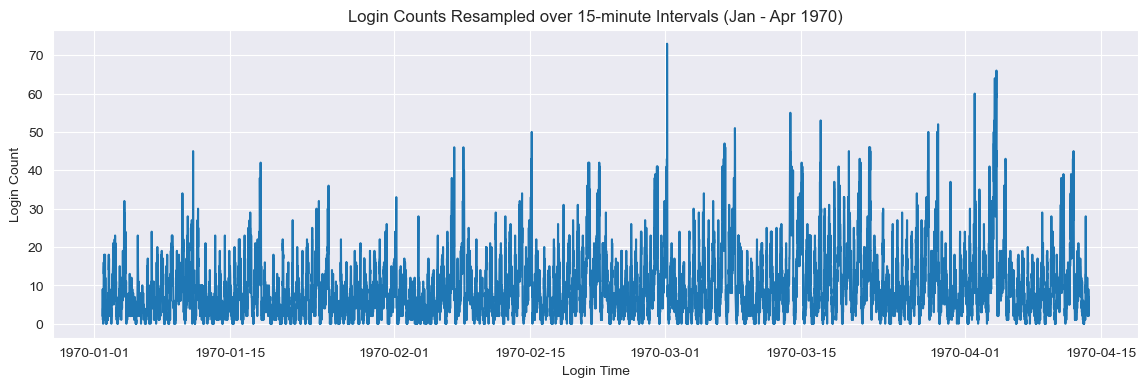

In [614]:
# Plotting the resampled data for the first week of January 1970
plt.figure(figsize=(14, 4))  # Set the figure size
sns.lineplot(data=df_logins_resampled_15min, x='login_time', y='visit_count')
plt.title('Login Counts Resampled over 15-minute Intervals (Jan - Apr 1970)')
plt.xlabel('Login Time')
plt.ylabel('Login Count')
plt.show()


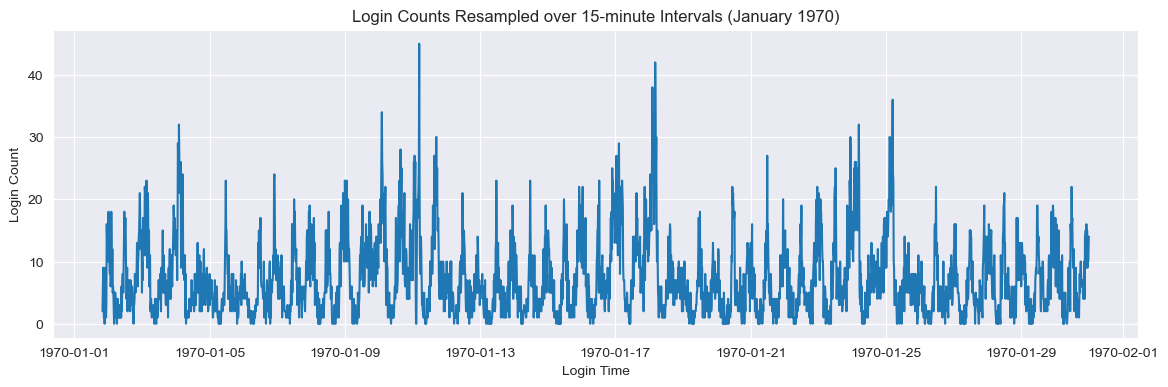

In [615]:
# Filter for January 1970
df_logins_first_week_jan = df_logins_resampled_15min[
    (df_logins_resampled_15min['login_time'] >= '1970-01-01') & 
    (df_logins_resampled_15min['login_time'] <= '1970-01-31')
]

# Plotting the resampled data for the first week of January 1970
plt.figure(figsize=(14,4))  # Set the figure size
sns.lineplot(data=df_logins_first_week_jan, x='login_time', y='visit_count')
plt.title('Login Counts Resampled over 15-minute Intervals (January 1970)')
plt.xlabel('Login Time')
plt.ylabel('Login Count')
plt.show()


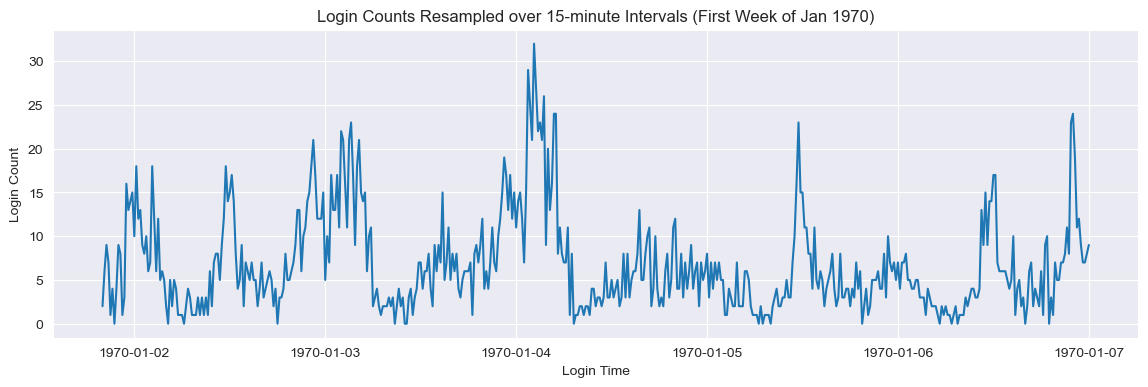

In [616]:
# Filter for January 1970
df_logins_first_week_jan = df_logins_resampled_15min[
    (df_logins_resampled_15min['login_time'] >= '1970-01-01') & 
    (df_logins_resampled_15min['login_time'] <= '1970-01-07')
]

# Plotting the resampled data for the first week of January 1970
plt.figure(figsize=(14,4))  # Set the figure size
sns.lineplot(data=df_logins_first_week_jan, x='login_time', y='visit_count')
plt.title('Login Counts Resampled over 15-minute Intervals (First Week of Jan 1970)')
plt.xlabel('Login Time')
plt.ylabel('Login Count')
plt.show()


### 2. Seasonal Pattern Analysis

Explore and visualize data aggregated by hour of the day, day of the week, and monthly to uncover any noticeable patterns. Use heatmaps and other visual tools for better illustration.

In [617]:
# Extract hour of day, day of the week, week number, and date (without time) for aggregation 
df_logins['hour'] = df_logins.index.hour
df_logins['day_of_week'] = df_logins.index.day_name()
df_logins['week_number'] = df_logins.index.isocalendar().week
df_logins['date'] = df_logins.index.date

# Now you have a 'week_number' column in df_logins
df_logins.head()

,hour,day_of_week,week_number,date
login_time,,,,
1970-01-01 20:13:18,20,Thursday,1,1970-01-01
1970-01-01 20:16:10,20,Thursday,1,1970-01-01
1970-01-01 20:16:37,20,Thursday,1,1970-01-01
1970-01-01 20:16:36,20,Thursday,1,1970-01-01
1970-01-01 20:26:21,20,Thursday,1,1970-01-01


#### Login Count by Hour of the Day (Grouped Daily)

There are two distinct peaks in login counts, one in the late night/early morning hours (around 1 - 2 AM), mid-day (10AM - 12PM) another in the late evening (around 10 - 11 PM), indicating high user activity during these times.

The login counts are lowest in the morning (around 5 AM to 9 AM), which could suggest lower demand or fewer drivers available during these hours.

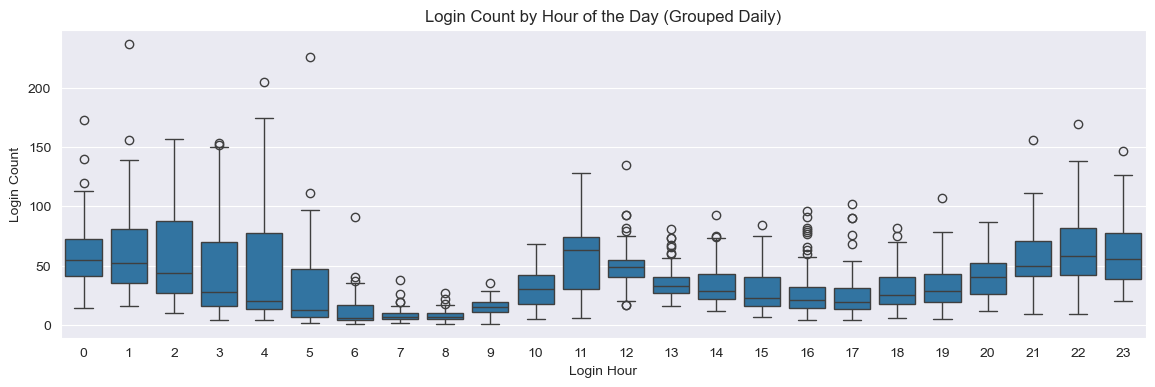

In [618]:
df_hourly_login_count_grouped_daily = df_logins.groupby(['date', 'hour']).size().to_frame(name='login_count').reset_index()

# Plotting the resampled data for the first week of January 1970
plt.figure(figsize=(14,4))  # Set the figure size
sns.boxplot(data=df_hourly_login_count_grouped_daily, x='hour', y='login_count')
plt.title('Login Count by Hour of the Day (Grouped Daily)')
plt.xlabel('Login Hour')
plt.ylabel('Login Count')
plt.show()

#### Login Count by Day of the Week (Grouped Weekly)

Login counts progressively increase throughout the week, with the lowest counts on Mondays and the highest on Saturdays, showing a trend towards higher usage as the week progresses towards the weekend.

The variance in login counts also increases from Monday to Sunday, with weekends, especially Saturdays, showing a wider range of login counts, which could indicate more variability in user activity during these days.

array([[<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'login_count'}>]], dtype=object)

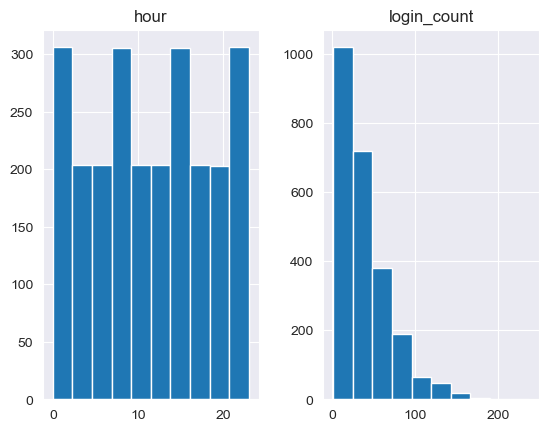

In [619]:
df_hourly_login_count_grouped_daily.hist()

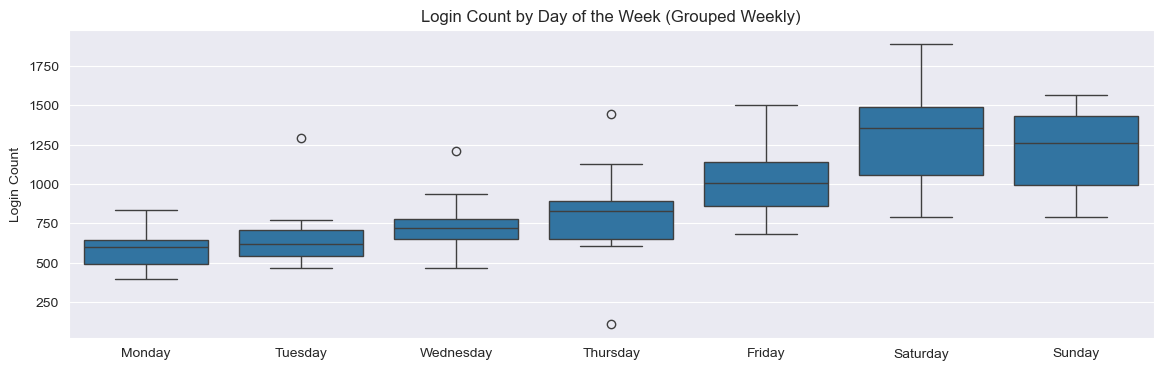

In [620]:
df_daily_login_count_grouped_weekly = df_logins.groupby(['week_number', 'day_of_week']).size().to_frame(name='login_count').reset_index()

# Plotting the resampled data for the first week of January 1970
plt.figure(figsize=(14,4))  # Set the figure size
sns.boxplot(data=df_daily_login_count_grouped_weekly, x='day_of_week', y='login_count', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Login Count by Day of the Week (Grouped Weekly)')
plt.xlabel('')
plt.ylabel('Login Count')
plt.show()

## Part 2 - A/B Test Experiment & Metrics Design

#### 1. Background & Problem Statement
To combat the limitations imposed by a toll bridge causing driver exclusivity to either Ultimate Gotham or Ultimate Metropolis, Ultimate managers propose reimbursing toll costs to encourage driver availability across both cities, aiming to optimize nighttime and daytime ridership.

&nbsp;
#### 2. Research Question and Hypotheses
The experiment aims to determine if reimbursing toll costs for drivers affects the availability of ridership across both cities during peak hours.
- Null Hypothesis (H0): Toll reimbursement has no effect on the ridership availability in both cities.
- Alternative Hypothesis (H1): Toll reimbursement leads to a significant change in ridership availability in both cities.

&nbsp;
#### 3. Key Metrics
- Operational Efficiency: Measured by the number of trips, specifically inter-city trips during peak hours, to assess if there is an increase in driver availability and cross-city ridership.
- Driver & Rider Satisfaction: Evaluated through post-trip ratings, looking for any statistically significant changes that could be attributed to eased cross-city travel.
- User Retention: Monitored by the rate of repeat usage, comparing the pre- and post-experiment periods for both groups of drivers.

&nbsp; 
#### 4. Sampling Methodology
To conduct a balanced A/B test, we will use stratified random sampling to create comparable control and treatment groups, categorizing drivers by their main operational city (Gotham or Metropolis), their typical working hours (day or night), and their preferred working days (weekdays or weekends). This breakdown ensures that both the control and treatment groups reflect the diversity of the driver pool, allowing for a fair comparison of the effects of toll reimbursement on driver behavior.

Group Defnition:
- Control Group: Drivers who will not receive toll reimbursement.
- Treatment Group: Drivers who will receive toll reimbursement.

&nbsp;
#### 5. Statistical Methods
- Comparative Analysis: Utilize the Independent Samples t-test or the Mann-Whitney U test, based on the normality of the distribution, to compare the key metrics between the control and treatment groups.
- Permutation Testing: Considered as a non-parametric alternative to the t-test to verify the significance without distribution assumptions.

 &nbsp;
#### 6. Results Interpretation & Limitations
- Interpretation of Results: The statistical significance will be determined by p-values from the tests, with a p-value less than 0.05 typically considered significant. However, practical significance will be evaluated based on the magnitude of the observed effects and their implications on operational efficiency and user satisfaction.
- Recommendations: Based on the results, we will advise the city operations team on the viability of toll cost reimbursement and its scalability, supported by the experiment's findings.
- Caveats and Limitations: The experiment's design assumes that drivers' behavior is influenced solely by toll cost reimbursement, without considering external factors such as changes in user demand or city events. The experiment's duration and seasonal factors might also impact the generalizability of the findings.


Few more considerations to keep in mind:
- Duration of the Experiment: The experiment is recommended to be long enough to capture the effects of the policy change while also short enough to remain relevant to business needs.
- Seasonal Variations: Consider potential seasonal effects that might impact driver behavior differently at different times of the year.
- Data Tracking and Integrity: Check for system to track the data accurately, such as: the number of tolls reimbursed, driver locations, and trip times.
- Communication with Participants: Develop a clear communication plan to inform participating drivers about the experiment's details, their assignment to groups, and the reimbursement process.
- Feedback Mechanisms: Implement mechanisms to gather feedback from drivers and riders, which could provide qualitative insights into the experiment's impact beyond the quantitative metrics.
- Ethical Considerations: Address any ethical concerns related to the experiment, such as the fairness of the reimbursement policy and the privacy of the drivers' data.
- Post-Experiment Analysis: Plan for a thorough post-experiment analysis that not only looks at the statistical significance of the results but also considers the business impact and scalability of implementing the toll reimbursement policy.
- Control for Confounders: Identify potential confounding variables that could affect the results (eg. changes in fuel prices that influences driver's behavior, city events that spikes demand regardless of toll incentives, marketing campaigns/other policy changes).

## Part 3 - Predictive Modeling for Rider Retention

TLDR; Summary:

The analysis conducted suggests that the number of days between sign-up and last trip is a significant predictor of user retention. Ultimate could implement early engagement strategies, such as incentives within the first few weeks of sign-up, to encourage ongoing platform use.

Users from King's Landing show a higher likelihood of retention. This could indicate that market-specific factors in King's Landing are conducive to user loyalty. Understanding these factors could guide similar strategies in other cities.

Being an Ultimate Black user also correlates with retention. Marketing efforts could focus on promoting the benefits of Ultimate Black to increase uptake and thus improve retention rates. Additionally, the average surge multiplier does not appear to deter users significantly. While keeping surge pricing competitive is essential, the model indicates that this alone is unlikely to influence long-term retention.

Features such as the percentage of trips with a surge and distance traveled in the first 30 days were also identified as influential. This suggests monitoring and perhaps offering special rates or rewards for frequent early usage or during surge periods to maintain a user's interest and prevent churn.

### 1. Data Wrangling

#### Display Missing Values

Missing values found in:
- **avg_rating_of_driver:** About 16% of missing values in "avg_rating_of_driver", need to confirm, but guessing because it's optional to rate a driver.
- **avg_rating_by_driver:** Might be similar as above but much lower missing values (<1%). Driver seemed to be more consistent in providing ratings after each trip.
- **phone:** There'a very small amount of missing data (<1%).

In [621]:
# Show missing values
print(f'Total Rows: {len(df_user_profile)}')
pd.concat(
    [
        df_user_profile.isnull().sum().sort_values(ascending=False),
        df_user_profile.isnull().mean().round(decimals=3)
    ],
    axis=1, # Concat by columns
    keys=['null_count', 'null_percentage']
).head(5)

Total Rows: 49992


,null_count,null_percentage
avg_rating_of_driver,8119,0.162
phone,396,0.008
avg_rating_by_driver,201,0.004
city,0,0.000
trips_in_first_30_days,0,0.000


#### Check if Data is Missing at Random

It seemed there's no pattern in the missing data, rather appeared at random.

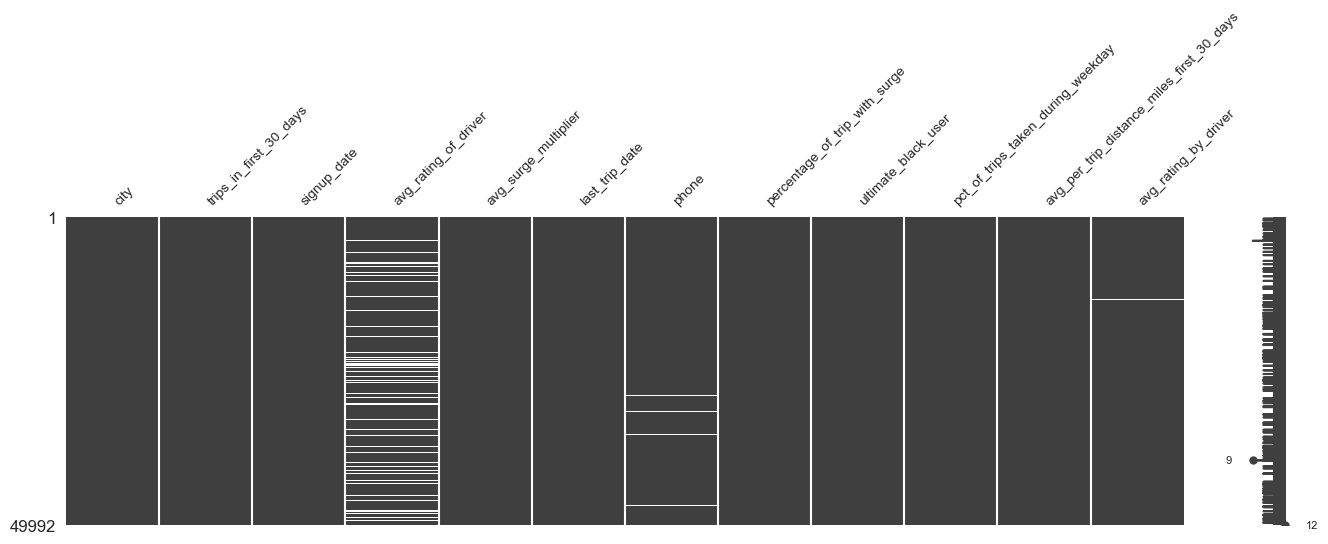

In [622]:
# To check if missing values are due to randomness
_ = msno.matrix(df_user_profile, figsize=(16, 4), fontsize=10)

#### Median Imputation of `avg_rating_of_driver` Column

We are implementing median value imputation for the `avg_rating_of_driver` column to address its 16% missing values. This approach is justified since the missingness appears random, and the median is selected over the mean due to the distribution's significant skew towards higher ratings. By using the median, we mitigate the influence of extreme values and more accurately preserve the dataset's central tendency.

count    41873.000000
mean         4.601512
std          0.617360
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64


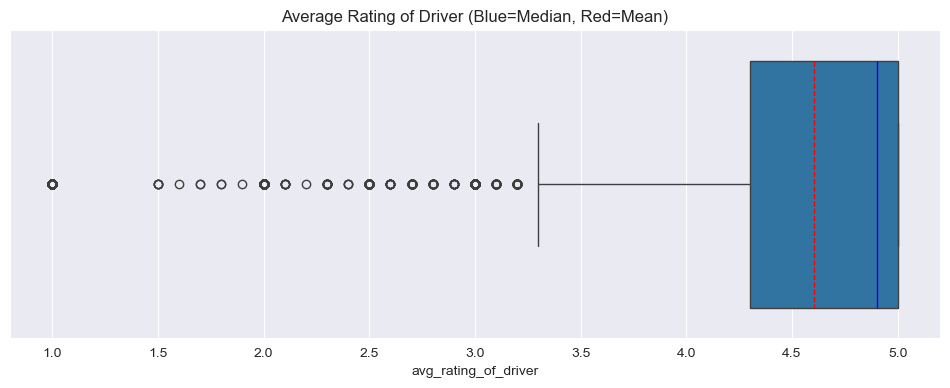

In [623]:
# Print the mean & median stats
print(df_user_profile['avg_rating_of_driver'].describe())

# Create boxplot
plt.figure(figsize=(12, 4))
_ = sns.boxplot(
    data=df_user_profile, 
    x='avg_rating_of_driver', 
    showmeans=True,
    meanline=True,
    meanprops={'color': 'red'},
    medianprops={'color': 'blue'}
).set_title(f'Average Rating of Driver (Blue=Median, Red=Mean)')
plt.show()

In [624]:
# Print a sample of missing value
missing_sample = df_user_profile[df_user_profile['avg_rating_of_driver'].isnull()]['avg_rating_of_driver'].sample(3)
missing_sample_index = missing_sample.index # To later check if imputation is successfully implemented
print(f'''Before median imputation
{missing_sample.sort_index()}
''')

# Perform Median Values imputation to the missing "avg_rating_of_driver"
df_user_profile['avg_rating_of_driver'].fillna(df_user_profile['avg_rating_of_driver'].median(), inplace=True)

# Confirm the sample has been imputed by median values
print(f'''Before median imputation
{df_user_profile[df_user_profile.index.isin(missing_sample_index)]['avg_rating_of_driver']}
''')

# Confirm successful imputation
print(f"Count of missing values (df_user_profile): {df_user_profile['avg_rating_of_driver'].isna().sum()}")

Before median imputation
3258    NaN
20971   NaN
33761   NaN
Name: avg_rating_of_driver, dtype: float64

Before median imputation
3258     4.9
20971    4.9
33761    4.9
Name: avg_rating_of_driver, dtype: float64

Count of missing values (df_user_profile): 0


#### Drop the Observations with Columns Containing <1% Missing Values

Given the very small number of missing values in "phone" and "avg_rating_by_driver" (<1%), we'll drop these observations. The data would also benefit with no additional assumptions introduced.

In [625]:
print(f'df_user_profile shape: {df_user_profile.shape}')

# Get observations where either "phone" or "avg_rating_by_driver" fields is null
drop_col_subset = ['phone', 'avg_rating_by_driver']
null_on_phone_or_ratingbydriver = df_user_profile[drop_col_subset].isnull().any(axis=1) # axis=1 is to check by columns
print(f'Rows to drop (either "phone" or "rating_by_driver" = NULL): {null_on_phone_or_ratingbydriver.sum()}')

# Drop the missing values
df_user_profile.dropna(subset=drop_col_subset, inplace=True)

# Confirm deletion
print(f'df_user_profile shape (after deletion): {df_user_profile.shape}')

df_user_profile shape: (49992, 12)
Rows to drop (either "phone" or "rating_by_driver" = NULL): 594
df_user_profile shape (after deletion): (49398, 12)


#### Confirming Successful Missing Values Treatment 

In [626]:
# Confirm no more missing values
df_user_profile.isnull().sum().sort_values(ascending=False)

city                                         0
trips_in_first_30_days                       0
signup_date                                  0
avg_rating_of_driver                         0
avg_surge_multiplier                         0
last_trip_date                               0
phone                                        0
percentage_of_trip_with_surge                0
ultimate_black_user                          0
pct_of_trips_taken_during_weekday            0
avg_per_trip_distance_miles_first_30_days    0
avg_rating_by_driver                         0
dtype: int64

### 2. Adopting Robust Scaler for Outlier Treatment
**NOTE:** Robust Scaling will be performed at "Data Preprocessing step below.

&nbsp;
**Legitimate Variances:**
Most outliers reflect genuine user behaviors, like high initial usage or frequent peak-time travel, providing valuable insights into user engagement and preferences.

**Mitigating Extreme Influence:**
A few outliers seem anomalous, such as consistent low ratings or excessive surge experiences. Applying a Robust Scaler reduces their impact, ensuring they don't skew the analysis while retaining their potential significance.

**Data Integrity Preservation:**
The Robust Scaler approach allows us to maintain the dataset's integrity, utilizing the median and IQR for scaling which are less outlier-sensitive than the mean.
Reasoning for Outlier Retention

**Modeling Integrity:**
Not discarding outliers keeps the richness of the data, essential for a nuanced understanding of customer experiences.
Further Investigation: Questionable outliers will be flagged for follow-up with system/database owners to determine if they're errors or part of natural user behavior patterns.

#### Get a random sample of outliers for each numerical columns

In [627]:
# Function to get a random outliers samples
def get_outliers_example(dataframe, sample_count=3):
    outliers_samples_dict = {}
    for column in dataframe.columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_indices = dataframe[(dataframe[column] < Q1 - outlier_step) | 
                                    (dataframe[column] > Q3 + outlier_step)].index
                                    
        # Check if there are more than three outliers to sample
        if len(outlier_indices) > 3:
            sample_indices = np.random.choice(outlier_indices, size=sample_count, replace=False)
        else:
            sample_indices = outlier_indices
        
        # Get the samples
        outlier_samples = dataframe.loc[sample_indices, column]
        
        outliers_samples_dict[column] = list(outlier_samples.values)
        
    return outliers_samples_dict

# Get the outliers sample
get_outliers_example(df_user_profile_numerical_only, sample_count=5)

{'trips_in_first_30_days': [11, 8, 16, 8, 10],
 'avg_rating_of_driver': [2.9, 3.0, 3.0, 3.0, 3.0],
 'avg_surge_multiplier': [1.5, 1.33, 1.13, 3.0, 1.54],
 'percentage_of_trip_with_surge': [25.0, 40.0, 25.0, 100.0, 33.3],
 'pct_of_trips_taken_during_weekday': [],
 'avg_per_trip_distance_miles_first_30_days': [21.52,
  21.65,
  18.94,
  20.5,
  20.85],
 'avg_rating_by_driver': [4.0, 4.0, 4.0, 3.0, 4.0]}

#### Distribution of Numerical Columns

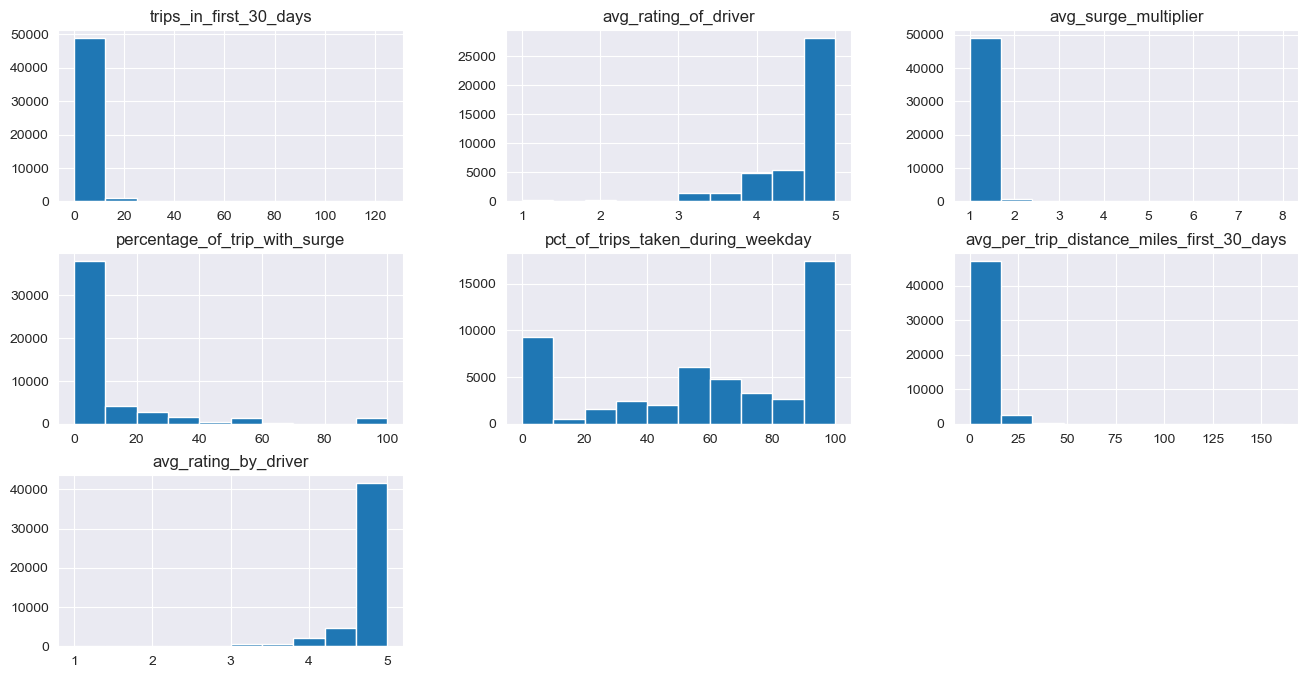

In [628]:
_ = df_user_profile_numerical_only.hist(figsize=(16, 8))

### 3. Feature Engineering & Correlation Analysis

For our predictive model, we have selected a set of features based on their correlation with user retention and their potential business impact:
- `days_elapsed_from_signup_to_last_trip` (Spearman Correlation: -0.83): New feature created, a strong negative correlation suggets users who churned tend to have lower days active in the platform (50 days by median, whereas active users have been in the platform for 150+ days by median).
- `avg_surge_multiplier` (Spearman Correlation: -0.24): Might need to clarify, but it seems surge price is negatively correlated with churned users (which is counter-intuitive).
- `city` (Cramer’s V: 0.28) and phone (Cramer’s V: 0.23): These categorical variables show substantial associations with retention, highlighting the importance of geographic and technological factors.
- `ultimate_black_user` (Cramer’s V: 0.21): Indicates some association with retention, which could reflect the influence of loyalty or premium service usage.
- `trips_in_first_30_days` (Spearman Correlation: -0.17): While not the most strongly correlated, this feature represents direct user engagement and is expected to be a predictor of retention.

Notably, `avg_rating_by_driver` exhibited a moderate positive correlation with retention (Spearman Correlation: 0.24), suggesting that users with higher ratings from drivers are more likely to churn. This counter-intuitive finding needs further investigation to understand its implications and whether it points to an underlying aspect of user behavior or service interaction that our model should account for.


#### New Feature 1 - User Churned

User is considered churned (no longer active) if they are not “active” (i.e. took a trip) in the preceding 30 days.

In [629]:
# We assume current date as the max of "last_trip_date" (Jul 1, 2014)
CURRENT_DATE = df_user_profile['last_trip_date'].max()

# Earliest date before user is classified as churned (not retained)
churn_cutoff_date = CURRENT_DATE - np.timedelta64(30, 'D')

# Marking if user took the trip in the preceding 30 days
df_user_profile['user_churned'] = df_user_profile['last_trip_date'] < churn_cutoff_date

df_user_profile['user_churned'].value_counts()

user_churned
True     30763
False    18635
Name: count, dtype: int64

#### New Feature 2 - Days Elapsed From Sign Up to Last Trip Date 

Calculate the number of days from sign-up to the last trip to identify potential churn patterns. For instance, if users typically stop using the service after 30 days, this can inform targeted retention strategies.

**Formula:**
days_elapsed_from_signup_to_last_trip = last_trip_date - signup_date

From below boxplot, it's quite interesting to find that on average people spent 50 days before they churned.

<Axes: xlabel='user_churned', ylabel='days_elapsed_from_signup_to_last_trip'>

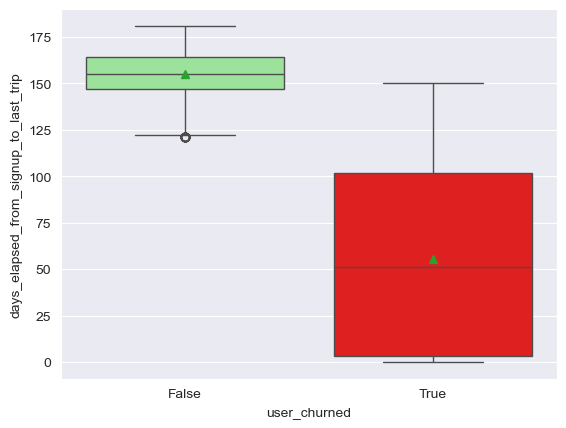

In [630]:
# To get the number of days elapsed since user signed up until the last date user took a trip
df_user_profile['days_elapsed_from_signup_to_last_trip'] = (
    (df_user_profile['last_trip_date'] - df_user_profile['signup_date']) / np.timedelta64(1, 'D')
).astype('int')

sns.boxplot(data=df_user_profile, x='user_churned', y='days_elapsed_from_signup_to_last_trip', palette={'True': 'red', 'False': 'lightgreen'}, showmeans=True)

#### New Feature 3 - Estimated Surge Impact

Estimate the surge pricing impact on users by multiplying the average surge multiplier by the number of trips and average distance traveled in the first 30 days. While using the average surge multiplier isn't perfect, it gives us a sense of how much extra users may be paying due to surge pricing, which can be insightful for understanding customer satisfaction and potential churn.

**Formula**:
est_miles_impacted_with_surge_first_30_days = avg_surge_multiplier x trips_in_first_30_days x avg_per_trip_distance_miles_first_30_days

From the boxplot below, it doesn't seem to provide a good indication between retained vs not-retained users.

<Axes: xlabel='user_churned', ylabel='est_miles_impacted_with_surge_first_30_days'>

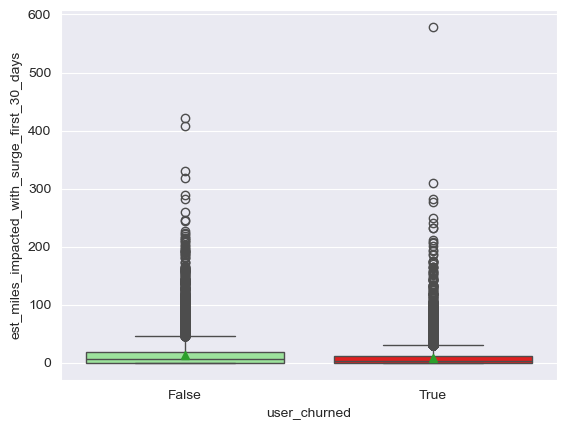

In [631]:
df_user_profile['est_miles_impacted_with_surge_first_30_days'] = (
    df_user_profile['avg_surge_multiplier']
    * df_user_profile['trips_in_first_30_days'] 
    * df_user_profile['avg_per_trip_distance_miles_first_30_days']
)

sns.boxplot(data=df_user_profile, x='user_churned', y='est_miles_impacted_with_surge_first_30_days', palette={'True': 'red', 'False': 'lightgreen'}, showmeans=True)

#### Spearman Correlation Analysis (Numerical Variables)

Spearman correlation analysis is used to capture the monotonic relationships between numerical variables, including our target variable `user_churned`. The heatmap visualization aids in identifying features that have a non-linear but consistent relationship with user retention, highlighted for emphasis.

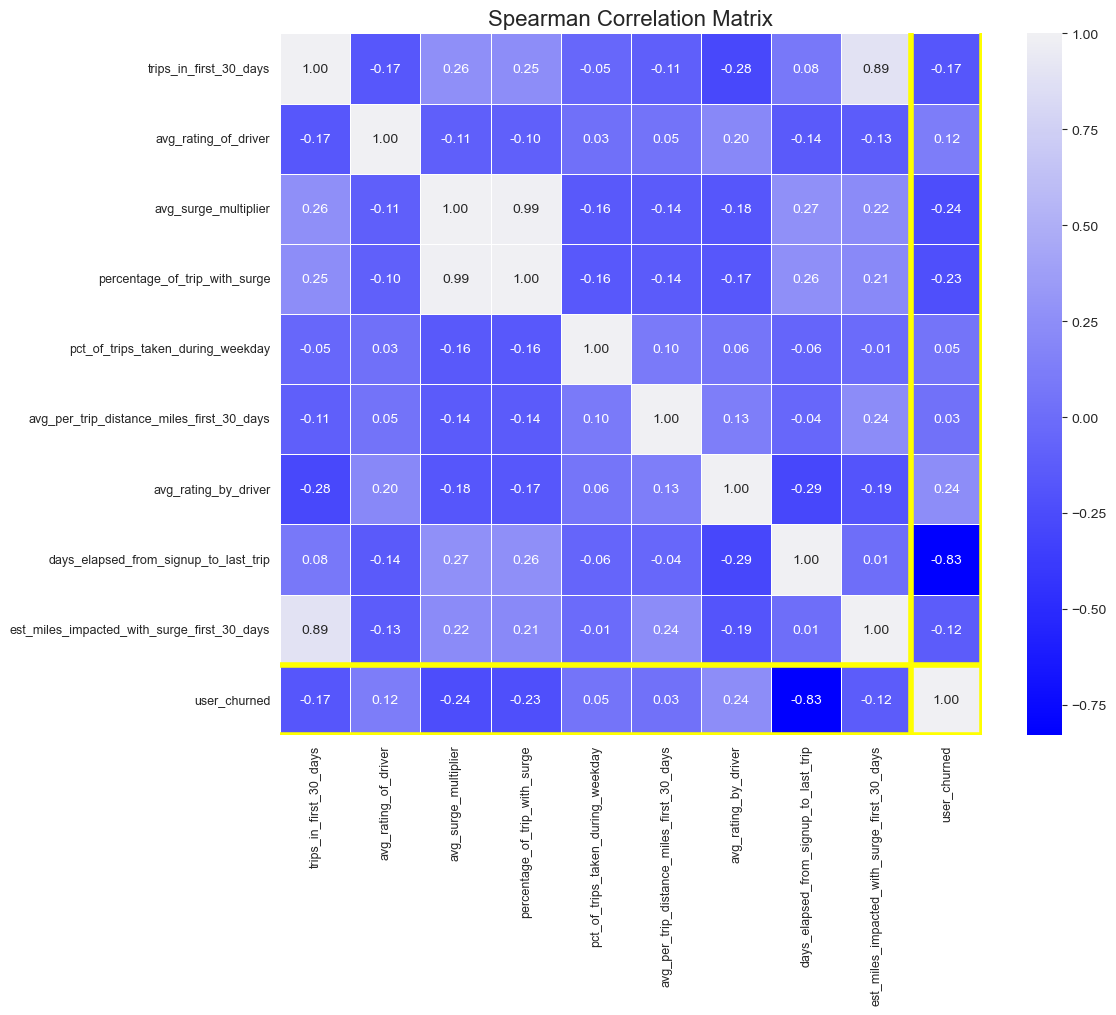

In [632]:
numerical_columns = list(df_user_profile.select_dtypes([float, int]).columns) + ['user_churned']

# Compute the Spearman correlation matrix including 'user_churned'.
spearman_correlation_matrix = df_user_profile[numerical_columns].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(12, 10))
cmap = sns.color_palette("light:b_r", as_cmap=True)
sns.heatmap(
    spearman_correlation_matrix, 
    annot=True, 
    fmt='.2f',
    cmap=cmap,
    square=True,
    linewidths=.5
)

# Highlighting 'user_churned' column and row
field_index = spearman_correlation_matrix.index.get_loc('user_churned')
plt.axhline(y=field_index, color='yellow', linewidth=4)
plt.axhline(y=field_index+1, color='yellow', linewidth=4)
plt.axvline(x=field_index, color='yellow', linewidth=4)
plt.axvline(x=field_index+1, color='yellow', linewidth=4)

# Title and labels
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# days_elapsed_from_signup_to_last_trip (0.83), avg_surge_multiplier (0.24), avg_rating_by_driver (-0.24), trips_in_first_30_days (0.17)

#### Chi-Square Cramer's V Correlation Analysis (Categorical Variables)

Chi-square tests for independence are performed to examine the relationships between categorical variables, with a focus on identifying any significant associations. The resulting p-values and chi-square statistics are consolidated into matrices for easy reference. Additionally, we computed Cramer's V to quantify the strength of association, allowing us to gauge not just the presence but also the magnitude of any relationships. These analyses will guide our understanding of the interplay between categorical features and inform the feature selection process for our predictive models.

In [633]:
# Assuming df_user_profile is your DataFrame and it includes categorical columns
categorical_columns = df_user_profile.select_dtypes([object, bool]).columns

# Define empty DataFrames to store Cramer's V values and p-values
cramerv_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
pvalues_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Loop over each pair of categories
for row in categorical_columns:
    for col in categorical_columns:
        # Create contingency table
        contingency_table = pd.crosstab(df_user_profile[row], df_user_profile[col])
        
        # Perform chi-square test to get the p-value
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        # Use scipy's association method to compute Cramer's V
        cramerv_value = stats.contingency.association(contingency_table, method='cramer')
        
        # Store the computed Cramer's V value and p-value in their respective matrices
        cramerv_matrix.loc[row, col] = cramerv_value
        pvalues_matrix.loc[row, col] = p_value

# Convert the Matrix DataFrame values to float
cramerv_matrix = cramerv_matrix.astype(float)
pvalues_matrix = pvalues_matrix.astype(float)


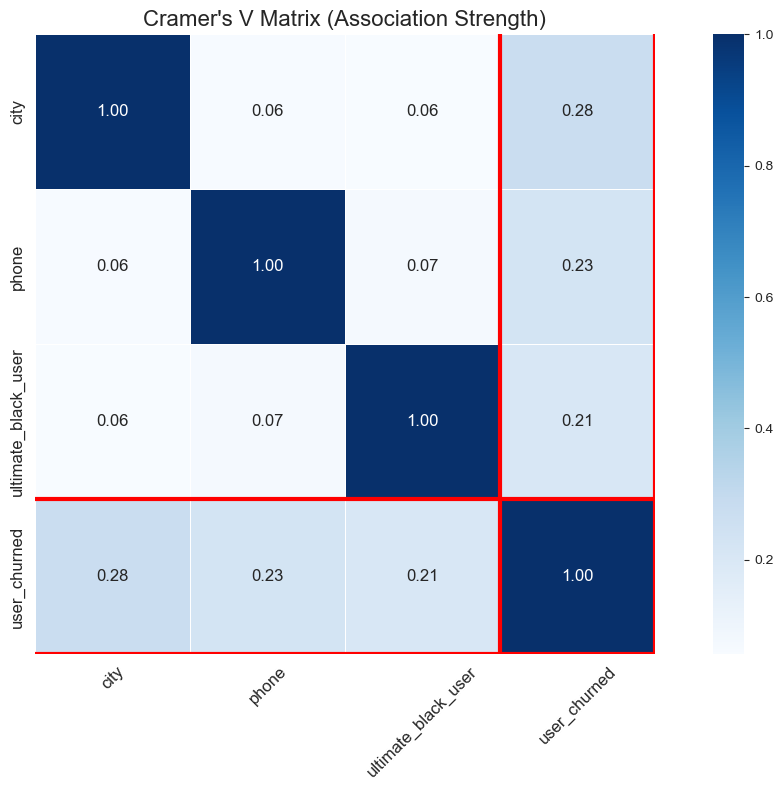

In [634]:
# Create a heatmap plot
_ = plt.figure(figsize=(12, 8))
# Create a custom color map
_ = sns.heatmap(
    cramerv_matrix, 
    annot=True, 
    fmt='.2f', # Ensure the annotation format is correct for floating-point numbers
    annot_kws={"size": 12},  # Adjust annotation font size if needed
    cmap='Blues',
    square=True,
    linewidths=.5
)

# Highlight the x and y-axis for a specific field name
field_name = 'user_churned'
_ = plt.axhline(y=cramerv_matrix.index.get_loc(field_name), color='red', linewidth=3)
_ = plt.axhline(y=cramerv_matrix.index.get_loc(field_name)+1, color='red', linewidth=3)
_ = plt.axvline(x=cramerv_matrix.columns.get_loc(field_name), color='red', linewidth=3)
_ = plt.axvline(x=cramerv_matrix.columns.get_loc(field_name)+1, color='red', linewidth=3)

# Set the title and display the plot
_ = plt.title("Cramer's V Matrix (Association Strength)", fontsize=16)
_ = plt.xticks(rotation=45, fontsize=12) # Rotate x labels
_ = plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

### 4. Data Preprocessing

#### Include Only Relevant Columns for Model Training 

In [635]:
# List of columns to keep
columns_to_keep = [
    'days_elapsed_from_signup_to_last_trip',
    'avg_surge_multiplier',
    'city',
    'phone',
    'ultimate_black_user',
    'trips_in_first_30_days',
    'user_churned' # The target variable
]

# Create a new DataFrame with only the necessary columns
df_model = df_user_profile[columns_to_keep]
print(df_model.shape)
df_model.head()

(49398, 7)


,days_elapsed_from_signup_to_last_trip,avg_surge_multiplier,city,phone,ultimate_black_user,trips_in_first_30_days,user_churned
0,143,1.10,King's Landing,iPhone,True,4,False
1,96,1.00,Astapor,Android,False,0,True
2,1,1.00,Astapor,iPhone,False,3,True
3,170,1.14,King's Landing,iPhone,True,9,False
4,47,1.19,Winterfell,Android,False,14,True


#### Train-Test Data Split

Train Shape (X, y): ((39518, 6), (39518,))
Test Shape (X, y): ((9880, 6), (9880,))


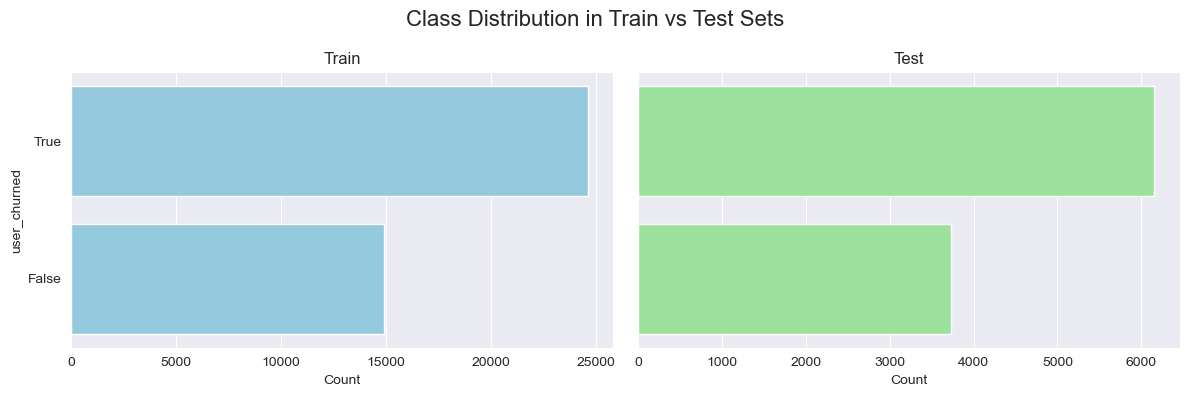

In [636]:
# Features and target variable
X = df_model.drop('user_churned', axis=1)  # Features
y = df_model['user_churned']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f'Train Shape (X, y): {X_train.shape, y_train.shape}')
print(f'Test Shape (X, y): {X_test.shape, y_test.shape}')

# Assuming y_train and y_test are your target variable series for train and test sets

# Train vs Test Class Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

# Using seaborn's countplot to show the distribution of classes
_ = sns.countplot(y=y_train, order=y_train.value_counts().index, ax=axes[0], color='skyblue')
axes[0].set_title('Train')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('user_churned')

_ = sns.countplot(y=y_test, order=y_train.value_counts().index, ax=axes[1], color='lightgreen')  # Using y_train order for consistency
axes[1].set_title('Test')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')

# Overall title for the figure
fig.suptitle('Class Distribution in Train vs Test Sets', fontsize=16)

plt.tight_layout()
plt.show()


#### Robust Scaler for Numerical Features

Apply RobustScaler to reduce the influence of outliers on the training data. Then, transform the test data using the same scaler.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [637]:
# Define columns to scale
numerical_columns_to_scale = ['days_elapsed_from_signup_to_last_trip', 'avg_surge_multiplier', 'trips_in_first_30_days']

# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train[numerical_columns_to_scale] = robust_scaler.fit_transform(X_train[numerical_columns_to_scale])
X_test[numerical_columns_to_scale] = robust_scaler.transform(X_test[numerical_columns_to_scale])

# Confirm scale is completed
X_train[numerical_columns_to_scale].head()

,days_elapsed_from_signup_to_last_trip,avg_surge_multiplier,trips_in_first_30_days
44096,-0.901639,0.0,0.000000
5005,0.360656,1.6,1.666667
29560,0.008197,1.2,4.666667
16961,0.000000,0.0,0.333333
13778,0.221311,0.0,0.333333


#### One-Hot Encode Categorical Variables

After scaling, apply one-hot encoding to the categorical variables in the training data. Then, transform the test data using the same encoder.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [539]:
# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(
    drop=None,
    sparse=False,  # Setting to False as we'll convert to dense array right after
    handle_unknown='ignore'
)

columns_to_encode = ['city', 'phone']

# Transform both train and test sets
train_encoded = one_hot_encoder.fit_transform(X_train[columns_to_encode])
test_encoded = one_hot_encoder.transform(X_test[columns_to_encode])

# Create DataFrame from the encoded categories for train and test sets
encoded_columns = one_hot_encoder.get_feature_names_out(columns_to_encode)
X_train_encoded = pd.DataFrame(train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded = pd.DataFrame(test_encoded, columns=encoded_columns, index=X_test.index)

# Drop original categorical columns and concatenate the new one-hot encoded columns
X_train = pd.concat(
    [
        X_train.drop(columns_to_encode, axis=1),
        X_train_encoded
    ],
    axis=1
)

X_test = pd.concat(
    [
        X_test.drop(columns_to_encode, axis=1),
        X_test_encoded
    ],
    axis=1
)

# Show sample data
X_train.head()


,days_elapsed_from_signup_to_last_trip,avg_surge_multiplier,ultimate_black_user,trips_in_first_30_days,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
44096,-0.901639,0.0,False,0.000000,0.0,0.0,1.0,1.0,0.0
5005,0.360656,1.6,True,1.666667,0.0,0.0,1.0,0.0,1.0
29560,0.008197,1.2,True,4.666667,1.0,0.0,0.0,0.0,1.0
16961,0.000000,0.0,False,0.333333,0.0,0.0,1.0,0.0,1.0
13778,0.221311,0.0,False,0.333333,0.0,1.0,0.0,0.0,1.0


### 4. Model Selection

Baseline Establishment: Used a Dummy Classifier to set a performance benchmark.

Model Exploration:
- Evaluated three models: Logistic Regression, Random Forest, and Gradient Boosting.
- Employed cross-validation to assess performance metrics (recall, precision, F1-score, AUC-ROC).

Performance Outcomes:
- Logistic Regression: Exhibited high performance across metrics with the benefits of lower computational requirements and model interpretability.
- Random Forest: Showed commendable performance but requires more computational resources.
- Gradient Boosting: Comparable performance to Logistic Regression but with higher computational demands and complexity.

**Model Selected: Logistic Regression**
- Reasoning: Despite the slight performance differences among the models, Logistic Regression was preferred for its balance of high performance, interpretability, and significantly lower computational requirements.
- Considerations: Its interpretability is advantageous for stakeholder communication and understanding the impact of features on predictions.

<img src="images/model_initial_result.png" alt="Initial Model Result" title="Initial Model Result" width="1200"/>


#### a. Custom Function to Evaluate Model Performance

In [560]:
def evaluate_model_with_cv(model, param_grid=None, X=X_train, y=y_train, cv_folds=5):
    """
    Evaluate a model using cross-validation and multiple metrics including recall, precision, f1-score, and ROC AUC.
    Perform a GridSearchCV to optimize hyperparameters if a parameter grid is provided.

    Parameters:
    model: The machine learning model to evaluate.
    param_grid: Dictionary with parameters names (str) as keys and lists of parameter settings to try.
    X: Features of the dataset.
    y: Labels of the dataset.
    cv_folds: Number of cross-validation folds.

    Returns:
    cv_results: The model or best model from GridSearchCV "best_estimator_"
    """
    
    # Define a stratified KFold for cross-validation
    stratified_k_fold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # If param_distributions is provided, perform randomized search for hyperparameters
    if param_grid:
        grid_search_cv = GridSearchCV(
            model,
            param_grid=param_grid,
            cv=stratified_k_fold, 
            scoring='roc_auc', # ROC-AUC curve
            verbose=2, # the computation time & score for each fold and parameter candidate is displayed
            n_jobs=11 # Use 11 of 12 CPU cores 
        )
        grid_search_cv.fit(X, y)
        print(f"Best Score: {grid_search_cv.best_score_}")
        print(f"Best Params: {grid_search_cv.best_params_}")
        model = grid_search_cv.best_estimator_
    
    # Fit the model on the training data to get the classification report
    model.fit(X, y)
    
    # Define scoring metrics
    scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'roc_auc': 'roc_auc'}

    # Perform cross-validation
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=stratified_k_fold, 
        scoring=scoring, 
        n_jobs=11 # Use 11 of 12 CPU cores
    )
    
    # Display results
    print('------------------------------------------------------------')
    print(f'MODEL: {model.__class__.__name__}')
    print(f"Cross-validated Recall: {cv_results['test_recall'].mean()}")
    print(f"Cross-validated Precision: {cv_results['test_precision'].mean()}")
    print(f"Cross-validated F1-Score: {cv_results['test_f1'].mean()}")
    print(f"Cross-validated ROC AUC: {cv_results['test_roc_auc'].mean()}")
    
    print('------------------------------------------------------------')
    
    return model


#### b. Evaluate Baseline Model Performance

In [548]:
# Initialize the DummyClassifier
baseline_model = DummyClassifier(strategy='stratified') # The dummy classifier predicts randomly based on the class original distribution

# Calculate metrics
evaluate_model_with_cv(model=baseline_model)

------------------------------------------------------------
MODEL: DummyClassifier
Cross-validated Recall: 0.6214953271028036
Cross-validated Precision: 0.6245881757065572
Cross-validated F1-Score: 0.6230297058076649
Cross-validated ROC AUC: 0.5011518040605588
------------------------------------------------------------


DummyClassifier(strategy='stratified')

#### c. Try Different (Non-Optimized) Models

In [549]:
# Initialize models
model_logistic_regression = LogisticRegression()
model_random_forest = RandomForestClassifier()
model_gradient_boosting = GradientBoostingClassifier()

# Create a dictionary of models
models = [model_logistic_regression, model_random_forest, model_gradient_boosting]

# Evaluate each model using cross-validation and recall as the metric
for model in models:
    evaluate_model_with_cv(model)


------------------------------------------------------------
MODEL: LogisticRegression
Cross-validated Recall: 0.9633888663145063
Cross-validated Precision: 0.9734885223106866
Cross-validated F1-Score: 0.9684066569889993
Cross-validated ROC AUC: 0.9947916559831969
------------------------------------------------------------
------------------------------------------------------------
MODEL: RandomForestClassifier
Cross-validated Recall: 0.9611133685493704
Cross-validated Precision: 0.966351524228857
Cross-validated F1-Score: 0.9637192618263863
Cross-validated ROC AUC: 0.9912350684314563
------------------------------------------------------------
------------------------------------------------------------
MODEL: GradientBoostingClassifier
Cross-validated Recall: 0.963835839089801
Cross-validated Precision: 0.9732242341197678
Cross-validated F1-Score: 0.9685008953915922
Cross-validated ROC AUC: 0.9951270124738325
------------------------------------------------------------


### 5. Model Hyperparameter Tuning (Model Selected: Logistic Regression)

#### Tuning 1 Result:

Best Score: 0.9946930865283967
Best Params: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'l1'}

MODEL: LogisticRegression
Cross-validated Recall: 0.9444534741974808
Cross-validated Precision: 0.9854273004970849
Cross-validated F1-Score: 0.9645000503339023
Cross-validated ROC AUC: 0.9946931137903146

In [ ]:
model_logistic_regression = LogisticRegression(
    solver='saga' # Choosing this since we want to try "elasticnet" penalty as well (only this solver supports)
)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # 'elasticnet' will require 'saga' solver
    'C': [0.1, 0.5, 1, 10],  # Range of regularization strength
    'class_weight': [None, 'balanced'],  # Handling imbalanced data
    'max_iter': [100, 300, 500],  # Ensure convergence
    'l1_ratio': [0, 0.5, 1]  # Only relevant with 'elasticnet' penalty
}

model_logistic_regression_grid_cv = evaluate_model_with_cv(
    model=model_logistic_regression,
    param_grid=param_grid
)


#### Tuning 2 Result:

Best ROC-AUC Score: 0.9947990788082925
Best Params: {'C': 0.05, 'class_weight': 'balanced', 'l1_ratio': 0.6, 'max_iter': 1100, 'penalty': 'l1'}

MODEL: LogisticRegression
Cross-validated Recall: 0.948151158065827
Cross-validated Precision: 0.9839030545340467
Cross-validated F1-Score: 0.9656924324548235
Cross-validated ROC AUC: 0.9947990788082925

In [ ]:
model_logistic_regression = LogisticRegression(
    solver='saga' # Choosing this since we want to try "elasticnet" penalty as well (only this solver supports)
)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # 'elasticnet' will require 'saga' solver
    'C': [0.05, 0.1, 0.5],  # Range of regularization strength
    'class_weight': [None, 'balanced'],  # Handling imbalanced data
    'max_iter': [500, 800, 1100],  # Ensure convergence
    'l1_ratio': [0.4, 0.5, 0.6]  # Only relevant with 'elasticnet' penalty
}

model_logistic_regression_grid_cv = evaluate_model_with_cv(
    model=model_logistic_regression,
    param_grid=param_grid
)


#### Tuning 3 Result:

Best Score: 0.994804577412347
Best Params: {'C': 0.05, 'max_iter': 2000}

MODEL: LogisticRegression
Cross-validated Recall: 0.9489232019504266
Cross-validated Precision: 0.9830842620348138
Cross-validated F1-Score: 0.9656990999548185
Cross-validated ROC AUC: 0.994804577412347


In [ ]:

model_logistic_regression = LogisticRegression(
    solver='saga', # Choosing this since we want to try "elasticnet" penalty as well (only this solver supports)
    class_weight='balanced',
    penalty='l1'
)

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5],  # Range of regularization strength
    'max_iter': [1500, 2000, 2500],  # Ensure convergence
}

model_logistic_regression_grid_cv = evaluate_model_with_cv(
    model=model_logistic_regression,
    param_grid=param_grid
)


### 6. Final Evaluation

Upon evaluating the performance of LogisticRegression() with various hyperparameter settings through GridSearchCV, it was observed that the default parameters already provide near-optimal performance. The marginal improvements achieved with hyperparameter tuning do not substantiate the increased complexity and computational resources required. Therefore, utilizing LogisticRegression() with its default settings offers a balanced approach, achieving high model performance efficiently while maintaining simplicity and interpretability.

#### Initialize the Model

In [571]:
model_logistic_regression = LogisticRegression()
model_logistic_regression.fit(X=X_train, y=y_train)
y_pred_test = model_logistic_regression.predict(X_test)

#### Confusion Matrix

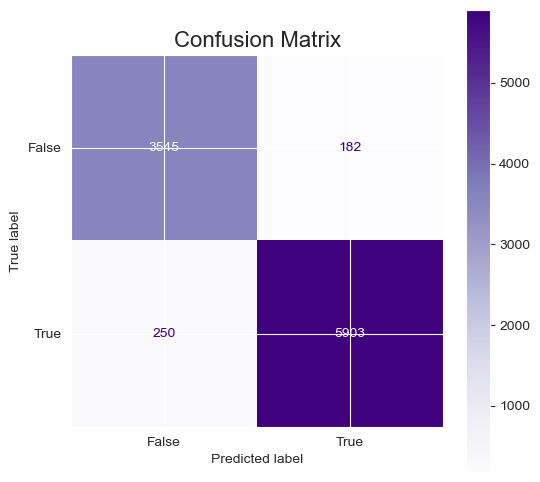

In [582]:
# Get unique labels
labels = model_logistic_regression.classes_

# Create Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Create a new figure with the desired size
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the confusion matrix and specify the colormap
plot = disp.plot(cmap='Purples', ax=ax)

# Set the title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.show()


#### Confusion Matrix (Normalized Recall Score)

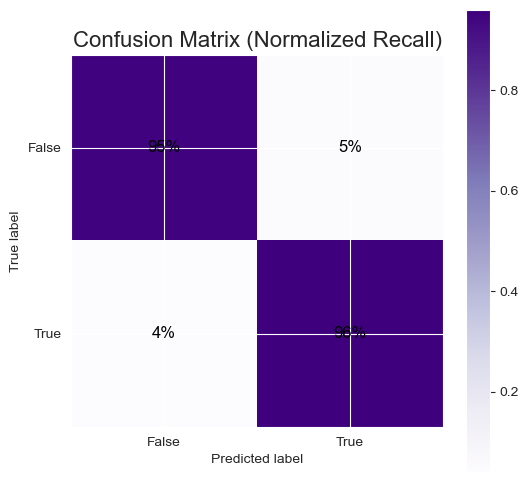

In [585]:
# Get unique labels
labels = model_logistic_regression.classes_

# Create Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test, normalize='true') # The normalize parameter is to show Recall score
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Create a new figure with the desired size
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the confusion matrix and specify the colormap
plot = disp.plot(cmap='Purples', ax=ax)

# Set the title
plt.title('Confusion Matrix (Normalized Recall)', fontsize=16)

# Remove the original annotations
for text in plot.text_.ravel():
    text.set_text("")

# Annotate the percentages with rounded format
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]*100:.0f}%", ha='center', va='center', color='black', fontsize=12)

# Show the plot
plt.show()


#### Classification Report

In [586]:
# Return Classification Report for the test set
classification_report_result = classification_report(
    y_true=y_test,
    y_pred=y_pred_test
)
print(f'''Test Set Classification Report:
{classification_report_result}
''')

Test Set Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      3727
        True       0.97      0.96      0.96      6153

    accuracy                           0.96      9880
   macro avg       0.95      0.96      0.95      9880
weighted avg       0.96      0.96      0.96      9880


#### Feature Importance

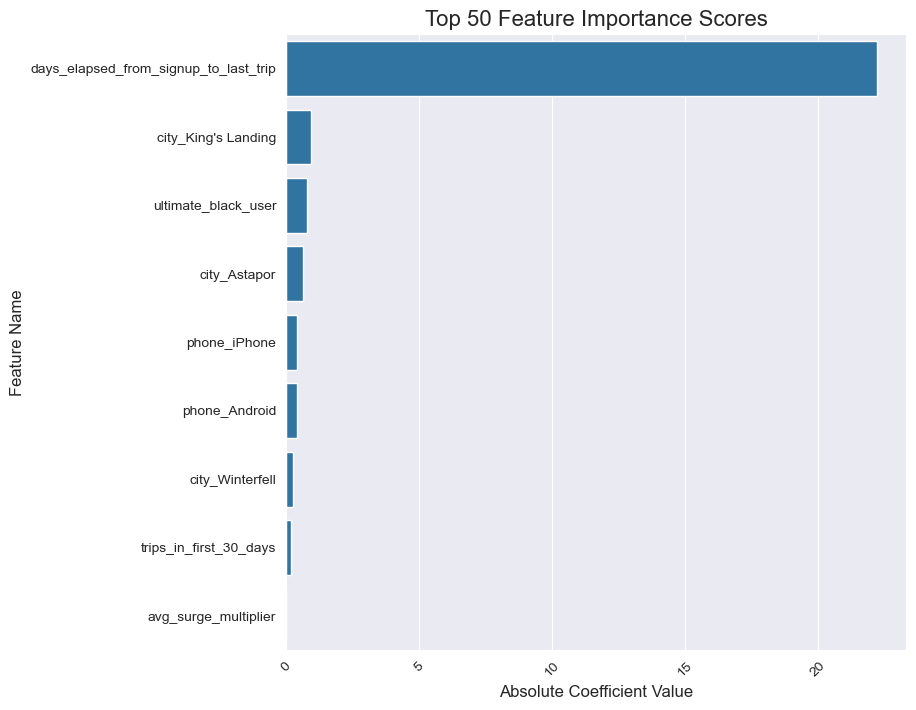

In [598]:
# Check if model has 'coef_' attribute
if hasattr(model_logistic_regression, 'coef_'):
    # Show top-50 Feature Scores
    N = 50

    # Create a dataframe containing feature names and the absolute coefficient values (making absolute because big positive & negative numbers both show importance/influence to the model outcome)
    df_feature_score = pd.DataFrame({
        'feature_name': model_logistic_regression.feature_names_in_,
        'score': np.abs(model_logistic_regression.coef_[0])
    }).sort_values('score', ascending=False)


    # Create the bar plot with adjusted figure size and font scale
    plt.figure(figsize=(8, 8))
    sns.barplot(data=df_feature_score.head(N), x='score', y='feature_name')

    # Set the title and axis labels
    plt.title(f"Top {N} Feature Importance Scores", fontsize=16)
    plt.xlabel("Absolute Coefficient Value", fontsize=12)
    plt.ylabel("Feature Name", fontsize=12)

    # Adjust the tick label size for better readability
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()
else:
    print("Model does not have coefficients for feature importance.")


--- End of Report ---